## Tutorial 3: Neural Machine Translation

### Sequence to Sequence model
RNN encoder-decoder architecture consists of two RNNs: an encoder RNN to summarize the whole input sequence $\pmb{x}$ into a single context vector $\pmb{c}$, and a decoder RNN to map that context vector $\pmb{c}$ back to a target sequence $\pmb{x}$. The context vector $\pmb{c}$ can be considered as a semantic presentation of input sequence.  In translation task, the target sentence should have the same semantic with the source sentence. Therefore, the idea of encoding sentence in source embedding space to a context vector and decoding it back to target embedding space makes RNN encoder-decoder a natural approach to neural machine translation.

RNN encoder-decoder model is also referred as sequence to sequence Seq2Seq model because it learns to predict output sequence $\pmb{y}$ given a input sequence $\pmb{x}$ where input sequence length and output sequence length may be different. 

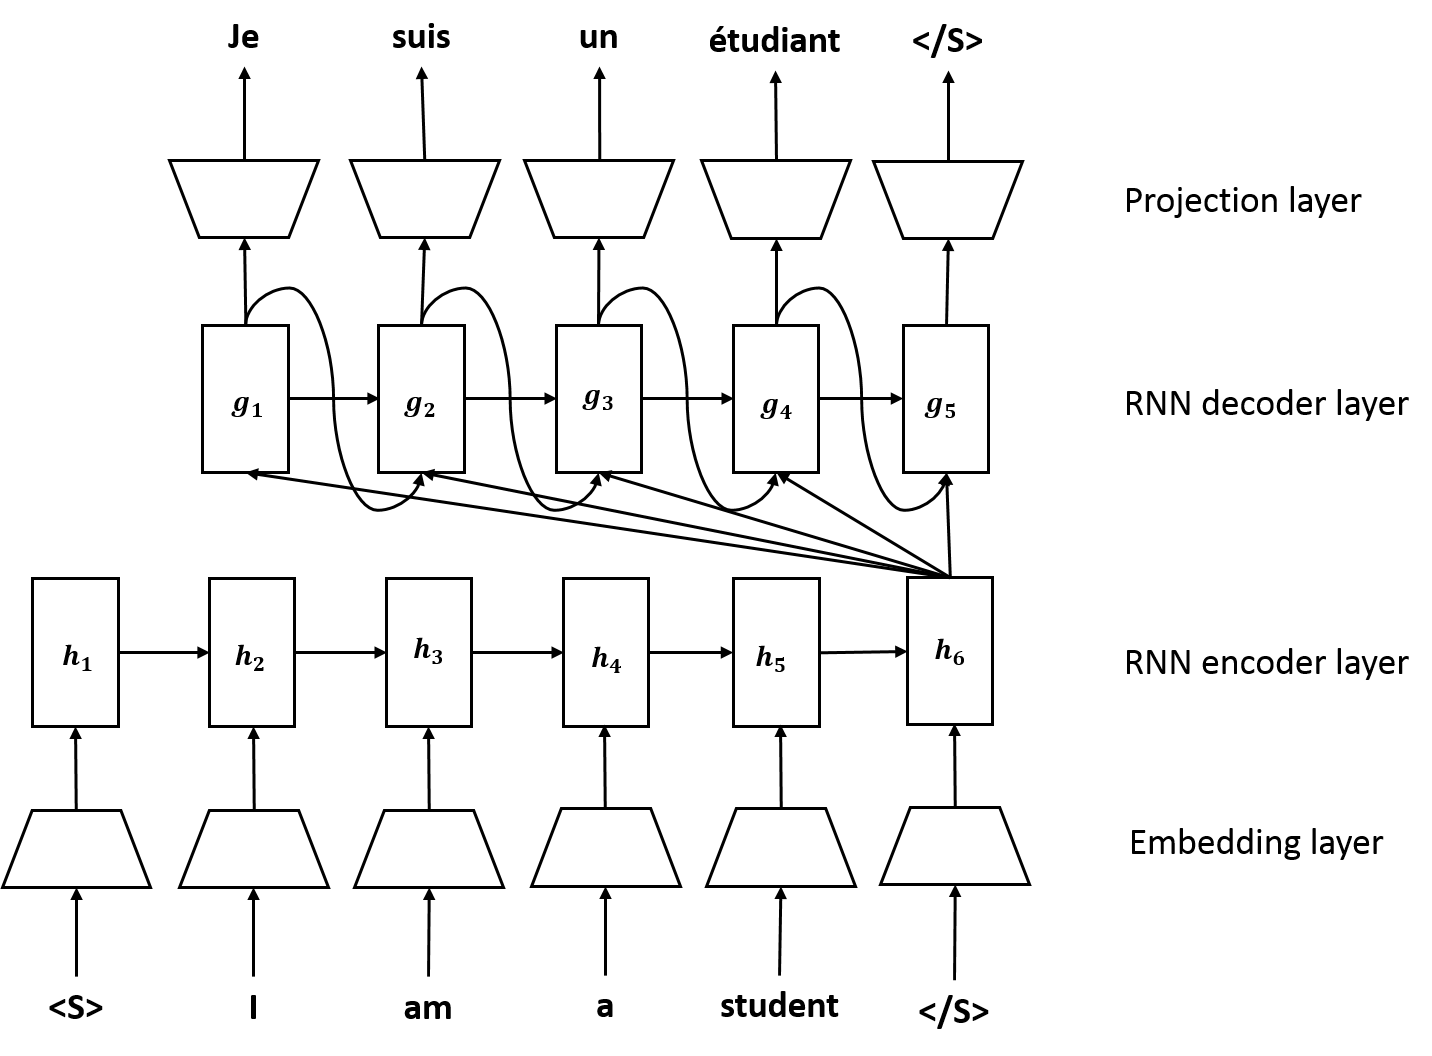

Above figure illustrates a sequence to sequence model for English-French translation. The hidden states of encoder RNN and decoder RNN at time step t are denotes as $h_t$ and $g_t$ respectively. The context vector $\pmb{c}$ is the final hidden state of RNN encoder
$$\pmb{c} = h_{|\pmb{x}|}$$

Encoding stage stops when reaching `<\S>` token in  source sentence. This special token also signals the decoder to start. Decoder generates the next token from the concatenation of context vector $\pmb{c}$ and previous generated token. It is worthwhile to mention that the same context vector $\pmb{c}$ is used during the whole decoding stage. Formally, decoder hidden state at time step $t$ is calculated as
$$g_t = RNN(g_{t-1}, [\pmb{c};y_{t-1}])$$

The next symbol of target sequence is estimated by the conditional probability given previous generated symbols
$$
P(\pmb{y}|\pmb{x}) = \prod_{t=1}^{n} P(y_{t}|\pmb{y}_{\le t-1}, \pmb{x}) \\
P(y_t|\pmb{y}_{\le t-1},\pmb{x}) = \textrm{softmax}(W_{\textrm{proj}}g_t + b_{\textrm{proj}})$$
where $W_{\textrm{proj}}$ and $b_{\textrm{proj}}$ are weight matrix and bias term of projection layer.

The encoder and decoder RNN are trained jointly to maximize the conditional log-likelihood
$$\theta^* = \max_\theta \frac{1}{N} \displaystyle \sum_{n-1}^N \log P (\pmb{y}|\pmb{x};\theta)$$
where $\theta$ is model parameters.

#### Data Preparation
We consider English-German machine translation task in this tutorial. Dataset for this tutorial can be found in folder `data/mt`. 

Load dataset

In [ ]:
def read_files(filename):
    with open(filename) as fin:
        data = fin.readlines()
        data = [" ".join(["<sos>",x]).replace("\n", " <eos>") for x in data]
    return [x.split() for x in data]
train_en = read_files('./data/mt/train.en')
train_de = read_files('./data/mt/train.de')
dev_en = read_files('./data/mt/dev.en')
dev_de = read_files('./data/mt/dev.de')
test_en = read_files('./data/mt/test.en')
test_de = read_files('./data/mt/test.de')

Construct English and German vocabulary

In [ ]:
import collections
#en_vocab
en_counter = collections.Counter([x for sublist in train_en for x in sublist])
en_count_pairs = sorted(en_counter.items(), key=lambda x: (-x[1], x[0]))
en_count_pairs.append(["<unk>", 1])
en_count_pairs.insert(0,["<mask>", 1])
en_vocab_size = len(en_count_pairs)
en_words, _ = list(zip(*en_count_pairs))
en_word_to_id = dict(zip(en_words, range(len(en_words))))


de_counter = collections.Counter([x for sublist in train_de for x in sublist])
de_count_pairs = sorted(de_counter.items(), key=lambda x: (-x[1], x[0]))
de_count_pairs.append(["<unk>", 1])
de_count_pairs.insert(0,["<mask>", 1])
de_vocab_size = len(de_count_pairs)
de_words, _ = list(zip(*de_count_pairs))
de_word_to_id = dict(zip(de_words, range(len(de_words))))

Convert words to index in vocabulary. Out-of-vocabulary words are replaced with `<unk>`

In [ ]:
en_unk_id = en_word_to_id["<unk>"]
de_unk_id = de_word_to_id["<unk>"]

train_en_ids = [[en_word_to_id.get(word, en_unk_id) for word in sent] for sent in train_en]
train_de_ids = [[de_word_to_id.get(word, de_unk_id) for word in sent] for sent in train_de]
dev_en_ids = [[en_word_to_id.get(word, en_unk_id) for word in sent] for sent in dev_en]
dev_de_ids = [[de_word_to_id.get(word, de_unk_id) for word in sent] for sent in dev_de]
test_en_ids = [[en_word_to_id.get(word, en_unk_id) for word in sent] for sent in test_en]
test_de_ids = [[de_word_to_id.get(word, de_unk_id) for word in sent] for sent in test_de]

#### Model Implementation in TensorFlow

In [ ]:
import tensorflow as tf
import numpy as np

Declare model input

In [ ]:
embedding_size = 128
hidden_size = 128
x = tf.placeholder(tf.int32, shape=(None, None), name="x")
y = tf.placeholder(tf.int32, shape=(None, None), name="y")

Declare model parameters

In [ ]:
src_embeddings = tf.get_variable("src_embeddings",[en_vocab_size, embedding_size],
                                 initializer=tf.random_normal_initializer())
tgt_embeddings = tf.get_variable("tgt_embeddings",[de_vocab_size, embedding_size],
                                initializer=tf.random_normal_initializer ())
W_softmax = tf.Variable(np.random.rand(hidden_size, de_vocab_size), name="W_softmax", dtype=tf.float32)
b_softmax = tf.Variable(np.zeros(de_vocab_size), name="b_softmax", dtype=tf.float32)

Embedding layer

In [ ]:
x_emb = tf.nn.embedding_lookup(src_embeddings, x)
y_emb = tf.nn.embedding_lookup(tgt_embeddings, y)

Encoder

Here we gonna use TensorFlow LSTM implementation

In [ ]:
#encoder
with tf.variable_scope('encoder') as scope:
    encoder_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=hidden_size)
    encoder_outputs, encoder_state = tf.nn.dynamic_rnn(cell=encoder_cell, inputs=x_emb, dtype=tf.float32)

Training Decoder

At training time, we feed true $y_{t-1}$ as input to decoder (teacher forcing)

Inference decoder

At inference time, ground truth label is not available. We use predicted output of previous timestep at input to decoder

In [ ]:
#decoder
with tf.variable_scope('decoder') as scope:
    y_shape = tf.shape(y_emb)
    time_steps = y_shape[1]
    
    #initial decoder output and states
    output = encoder_outputs[-1]
    state = encoder_state
    context = encoder_state
    decoder_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=hidden_size)
    decoder_inputs = tf.transpose(y_emb, [1,0,2])
        
    def while_loop_cond(i,decoder_outputs, output, state):
        return tf.less(i, time_steps)
    
    def while_body(i, decoder_outputs, output, state):
        # feed true y_i-1 
        output, state = decoder_cell(tf.concat([context,decoder_inputs[i]],1), state)
        logit = tf.nn.xw_plus_b(output, W_softmax, b_softmax)
        decoder_outputs = decoder_outputs.write(i, logit)
        return [tf.add(i, 1), decoder_outputs, output, state]
    init_outputs = tf.TensorArray(tf.float32, size=time_steps)
    i, decoder_outputs, output, state = tf.while_loop(while_loop_cond, while_body,
                                                      [tf.constant(0), init_outputs, output, state])
    decoder_outputs = decoder_outputs.stack()
    decoder_outputs = tf.transpose(decoder_outputs, [1, 0, 2])
    
    
    # inference decoder
    max_step = 40
    inf_output = encoder_outputs[-1]
    inf_state = encoder_state
    def while_loop_inference_cond(i,decoder_outputs, output, state, symbol):
        return tf.less(i, max_step)
    
    def while_inference_body(i, inference_decoder_outputs, output, state, decoder_input):
        
        output, state = decoder_cell(tf.concat([context,decoder_input],1), state)
        logit = tf.nn.xw_plus_b(output, W_softmax, b_softmax)
        decoder_input = output
#         input_symbol = tf.argmax(logit, axis = 1, output_type=tf.int32)[0]
#         inference_decoder_outputs = inference_decoder_outputs.write(i, input_symbol)
        inference_decoder_outputs = inference_decoder_outputs.write(i, logit)
        return [tf.add(i, 1), inference_decoder_outputs, output, state, decoder_input]
    
#     inference_init_outputs = tf.TensorArray(tf.int32, size=max_step)
    init_decoder_input = tf.nn.embedding_lookup(tgt_embeddings, [de_word_to_id['<sos>']])
    inference_init_outputs = tf.TensorArray(tf.float32, size=max_step)
    i, inference_decoder_outputs, output, state, symbol = tf.while_loop(while_loop_inference_cond, while_inference_body,
                                                                [tf.constant(0), inference_init_outputs, inf_output, inf_state, init_decoder_input])
    inference_decoder_outputs = inference_decoder_outputs.stack()
    inference_decoder_outputs = tf.transpose(inference_decoder_outputs, [1, 0, 2])
    

Project layer

In [ ]:
pred_op = tf.argmax(decoder_outputs, 2)
inference_pred_op = tf.argmax(inference_decoder_outputs,2)

Compute cross entropy loss

In [ ]:
seq_len = tf.placeholder(tf.int32, shape=[None], name="seq_len")
mask = tf.sequence_mask(seq_len, tf.shape(y)[1], dtype=tf.float32)
crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=decoder_outputs, labels=y)
loss_op = tf.reduce_mean(tf.reduce_sum(tf.multiply(crossent,mask), axis = 1))

Declare optimizer

In [ ]:
# optimize with SGD, learning rate = 0.001
train_op = tf.train.GradientDescentOptimizer(0.001).minimize(loss_op)


#### Training model
Init TensorFlow session

In [ ]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

Training loop

In [ ]:
train_sets = np.stack((train_en_ids, train_de_ids), axis=1)
np.random.shuffle(train_sets)
num_epoch = 10
batch_size = 50
num_step = int(len(train_sets) / batch_size)
history_loss = []
history_dev_loss = []
history_dev_acc = []

def padding(array):
    max_len = len(max(array,key=len))
    return [np.pad(x,(0,max_len-len(x)),'constant') for x in array]

dev_x = padding(dev_en_ids)
dev_y_len = [len(s) for s in dev_de_ids]
dev_y = padding(dev_de_ids)


for epoch in range(num_epoch):
    #Shuffle training data
    np.random.shuffle(train_sets)
    for step in range(num_step):
        minibatch = train_sets[step*batch_size:(step+1)*batch_size]
        batch_x = np.asarray(minibatch)[:,0].tolist()
        batch_x = padding(batch_x)
        batch_y = np.asarray(minibatch)[:,1].tolist()
        y_len = [len(s) for s in batch_y]
        batch_y = padding(batch_y)
        loss, tr, pr = sess.run([loss_op, train_op, pred_op], feed_dict={x: batch_x, y: batch_y, seq_len: y_len})
        if (step + 1) % 50 == 0:                
            #run on validation set after every 100 step
            dev_loss, pred = sess.run([loss_op, pred_op], feed_dict={x: dev_x, y: dev_y, seq_len: dev_y_len})
            history_dev_loss.append(dev_loss)
            history_loss.append(loss)
            print("Epoch " + str(epoch) + " Step " + str(step) + ", Minibatch Loss= " + \
              "{:.4f}".format(loss) + ", Dev loss {:.4f}".format(dev_loss))

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history_loss, 'r')
plt.plot(history_dev_loss, 'b')

#### Inference
Using greedy search

In [ ]:
result = []
for en,de in zip(test_en_ids,test_de_ids):
    pred = sess.run(inference_pred_op, feed_dict={x: [en]})
    en_sent = [en_words[id] for id in en]
    de_sent = [de_words[id] for id in de]
    pred_sent = [de_words[id] for id in pred[0]]
    print("=======")
    print("EN: " + " ".join(en_sent))
    print("REF: " + " ".join(de_sent))
    print("DE: " + " ".join(pred_sent))

### Sequence to Sequence model with attentions
Due to vanishing and exploding gradient problem, learning long dependency is still an open challenge for RNN. Summarizing input sequence into a fixed context vector is not sufficient in transducing long sentence. The context vector $\pmb{c}$ is not able to summarize well tokens appearing in the very beginning of very long source sentence. 

Bidirectional source RNN with soft attention mechanism was introduced to address this problem. Attention mechanism is used to associate current output symbol with some particular symbols in the source sentence. It can be considered as an alignment model between source and target sentence in the context of machine translation task. Although the whole source sentence context is important, the lexical choice of a word in target sentence is more likely related to the existence of some words than others in source sentence. Therefore, it is easy to understand the motivation of giving some words more weight than others.

Bidirectional RNN comprises a forward and a backward hidden layers. Forward hidden layer reads input sequence from the beginning to end, resulted in a sequence of forward hidden states $(\overrightarrow{h}_1,...,\overrightarrow{h}_{|x|})$. Backward hidden layer processes input in reverse order and computes backward hidden states $(\overleftarrow{h}_1,...,\overleftarrow{h}_{|x|})$. Standard unidirectional RNN  processes sequences using past context obtained by the forward hidden layers. By adding a reverse direction layer, bidirectional RNN are able to capture the surrounding context of words in input sentence.

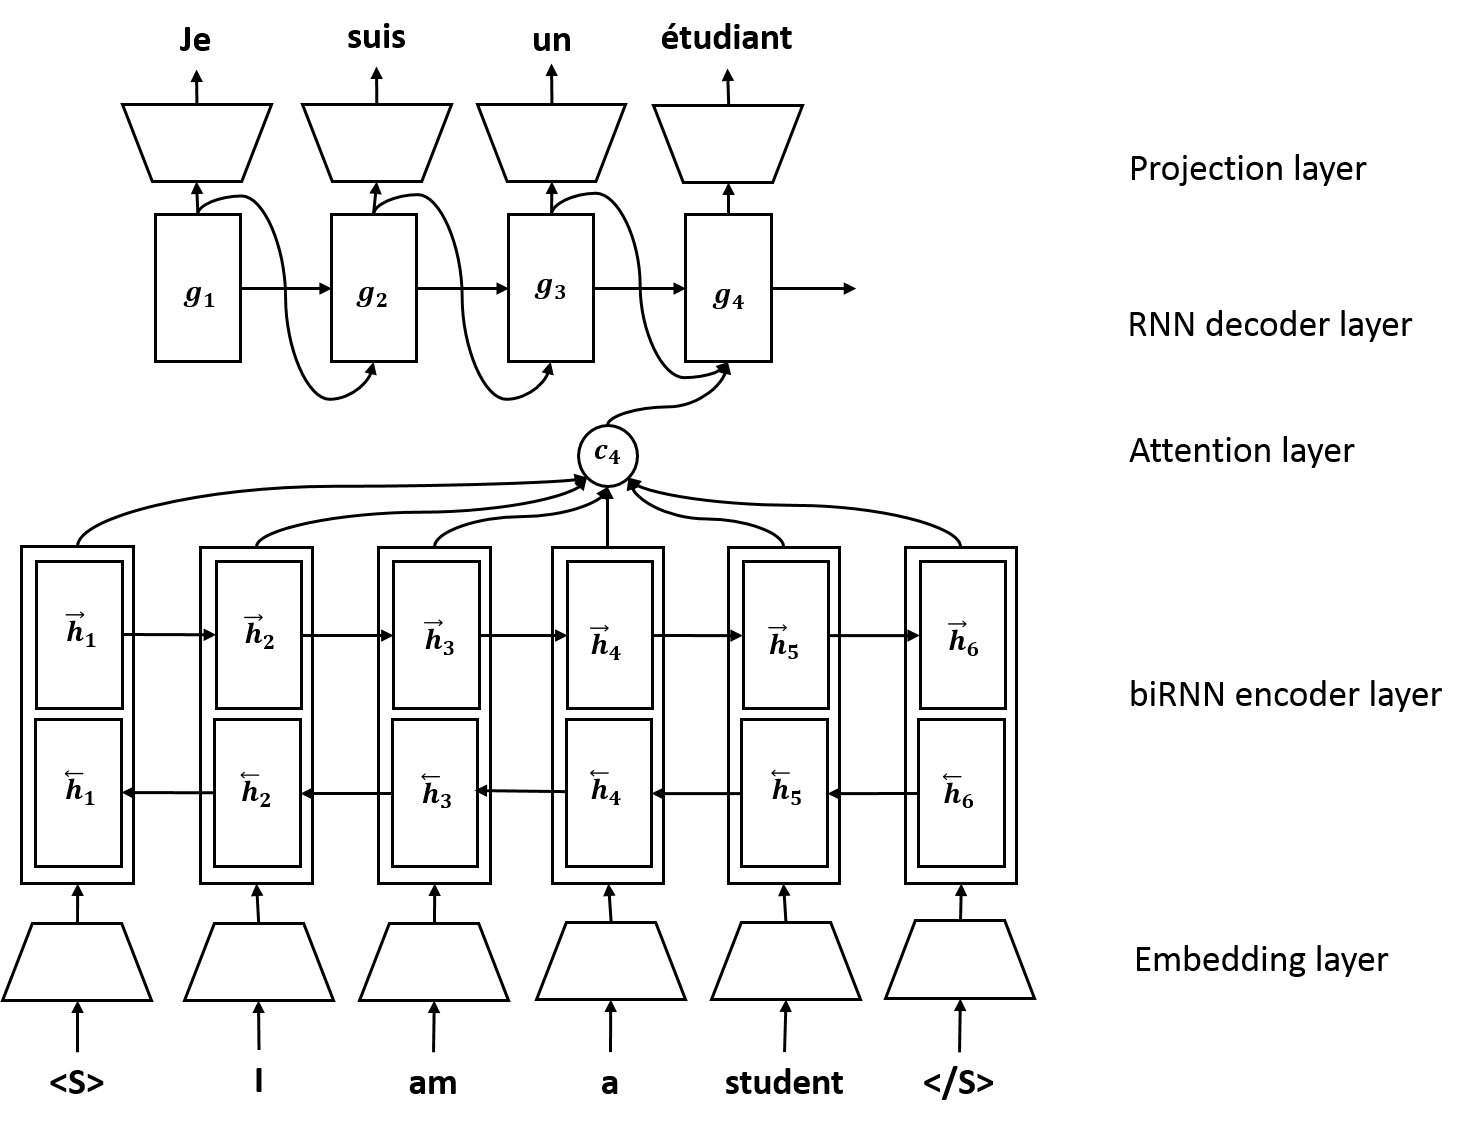
*Sequence to sequence model with bidirectional RNN and attention mechanism*

This model is different from the sequence to sequence model described above  on the calculation of encoder hidden states and context vector. The encoder hidden state $h_i$ is constructed by concatenating the forward and backward hidden state together
$$
h_i = [\overrightarrow{h}_i;\overleftarrow{h}_i] \\
\overrightarrow{h}_i = \text{RNN}(\overrightarrow{h}_i-1, x_i) \\
\overleftarrow{h}_i = \text{RNN}(\overleftarrow{h}_i+1,x_i) 
$$

In decoding stage, context vector $\pmb{c}$ at time step $t$ is calculated as a weighted sum of encoder hidden state
$$
\pmb{c}_t = \displaystyle \sum_{j=1}^{|x|} \alpha_{tj}h_j\\ 
\alpha_{tj} = \textrm{softmax}(e_{tj}) \\
e_{tj} = \textrm{a}(g_{t-1},h_j)
$$
where $\textrm{a}(g_{t-1},h_j)$ is an alignment model that evaluates how well decoder hidden state and encoder hidden state associates with each other. One frequent choice of function $\textrm{a}$ is the $\tanh$ function
$$
e_{tj} = v_{attn}^T\tanh(W_{attn}g_{t-1} + U_{attn}h_j+b_{attn})
$$
where $v_{attn}^T$, $W_{attn}$, $U_{attn}$, $b_{attn}$ is model parameters. The attention mechanism is learned together with other parameters of \textsc{Seq2Seq} model. It is often referred as soft attention mechanism as it computes a weighted sum of the encoder states.

#### TensorFlow implementation

Encoder

In [ ]:
#birnn encoder
with tf.variable_scope('birnn_encoder') as scope:
    fwd_encoder_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=hidden_size)
    bwd_encoder_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=hidden_size)
    birnn_encoder_outputs, birnn_encoder_state = tf.nn.bidirectional_dynamic_rnn(cell_fw=fwd_encoder_cell , cell_bw=bwd_encoder_cell, 
                                                                     inputs=x_emb, dtype=tf.float32)

In [ ]:

birnn_encoder_states = tf.concat([birnn_encoder_outputs[0],birnn_encoder_outputs[1]],2)
birnn_encoder_state = birnn_encoder_state[0]

Decoder

In [ ]:
attn_size = 128
x_seq_len = tf.placeholder(tf.int32, shape=[None], name="x_seq_len")
y_seq_len = tf.placeholder(tf.int32, shape=[None], name="y_seq_len")
W_attn = tf.Variable(np.random.rand(3 * hidden_size, attn_size), name="W_attn", dtype=tf.float32)
b_attn = tf.Variable(np.zeros(attn_size), name="b_attn", dtype=tf.float32)
V_attn = tf.Variable(np.random.rand(attn_size), name="W_attn", dtype=tf.float32)

In [ ]:
#decoder
with tf.variable_scope('attn_decoder') as scope:
    y_shape = tf.shape(y_emb)
    time_steps = y_shape[1]
    
    #initial decoder output and states
    output = birnn_encoder_state
    state = birnn_encoder_state
    attn_decoder_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=hidden_size)
    decoder_inputs = tf.transpose(y_emb, [1,0,2])
    encoder_mask = tf.sequence_mask(x_seq_len, tf.shape(birnn_encoder_states)[1], dtype=tf.float32)
    def get_attention_vector(encoder_states, decoder_state):
        steps = tf.shape(encoder_states)[1]
        g = tf.tile(tf.expand_dims(decoder_state,1),[1,steps,1]) # batch_size x timestep x hidden_size
        
        e = tf.tanh(tf.add(tf.einsum('ijk,ka->ija', tf.concat([g,encoder_states],2), W_attn),b_attn)) # batch_size x timestep x attn_size
        scores = tf.nn.softmax(tf.einsum('ijk,k->ij',e, V_attn))
        context = tf.reduce_sum(tf.expand_dims(scores * encoder_mask, 2) * encoder_states, axis=1) #batch_size x hidden_size
        return context
        
    def while_loop_cond_attn(i,decoder_outputs, output, state):
        return tf.less(i, time_steps)
    
    def while_body_attn(i, decoder_outputs, output, state):
        # feed true y_i-1 
        context = get_attention_vector(birnn_encoder_states, state)
        output, state = attn_decoder_cell(tf.concat([context,decoder_inputs[i]],1), state)
        logit = tf.nn.xw_plus_b(output, W_softmax, b_softmax)
        decoder_outputs = decoder_outputs.write(i, logit)
        return [tf.add(i, 1), decoder_outputs, output, state]
    init_outputs = tf.TensorArray(tf.float32, size=time_steps)
    i, decoder_attn_outputs, output, state = tf.while_loop(while_loop_cond_attn, while_body_attn,
                                                      [tf.constant(0), init_outputs, output, state])
    decoder_attn_outputs = decoder_attn_outputs.stack()
    decoder_attn_outputs = tf.transpose(decoder_attn_outputs, [1, 0, 2])
    
    
    # inference decoder
    max_step = 40
    inf_output = birnn_encoder_state
    inf_state = birnn_encoder_state
    def while_loop_inference_cond_attn(i,decoder_outputs, output, state, symbol):
        return tf.less(i, max_step)
    
    def while_inference_body_attn(i, inference_decoder_outputs, output, state, decoder_input):
        context = get_attention_vector(birnn_encoder_states, state)
        output, state = attn_decoder_cell(tf.concat([context,decoder_input],1), state)
        logit = tf.nn.xw_plus_b(output, W_softmax, b_softmax)
        decoder_input = output
#         inference_decoder_outputs = inference_decoder_outputs.write(i, input_symbol)
        inference_decoder_outputs = inference_decoder_outputs.write(i, logit)
        return [tf.add(i, 1), inference_decoder_outputs, output, state, decoder_input]
    
    init_decoder_input = tf.nn.embedding_lookup(tgt_embeddings, [de_word_to_id['<sos>']])
    inference_init_outputs = tf.TensorArray(tf.float32, size=max_step)
    i, inference_attn_decoder_outputs, output, state, symbol = tf.while_loop(while_loop_inference_cond_attn, while_inference_body_attn,
                                                                [tf.constant(0), inference_init_outputs, inf_output, inf_state, init_decoder_input])
    inference_attn_decoder_outputs = inference_attn_decoder_outputs.stack()
    inference_attn_decoder_outputs = tf.transpose(inference_attn_decoder_outputs, [1, 0, 2])
    

In [ ]:
attn_pred_op = tf.argmax(decoder_attn_outputs, 2)
attn_inference_pred_op = tf.argmax(inference_attn_decoder_outputs,2)
decoder_mask = tf.sequence_mask(y_seq_len, tf.shape(y)[1], dtype=tf.float32)
attn_crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=decoder_attn_outputs, labels=y)
attn_loss_op = tf.reduce_mean(tf.reduce_sum(tf.multiply(attn_crossent,decoder_mask), axis = 1))
attn_train_op = tf.train.GradientDescentOptimizer(0.001).minimize(attn_loss_op)

In [ ]:
attn_sess = tf.Session()
attn_sess.run(tf.global_variables_initializer())

In [ ]:
train_sets = np.stack((train_en_ids, train_de_ids), axis=1)
np.random.shuffle(train_sets)
num_epoch = 10
batch_size = 50
num_step = int(len(train_sets) / batch_size)
history_loss = []
history_dev_loss = []
history_dev_acc = []

def padding(array):
    max_len = len(max(array,key=len))
    return [np.pad(x,(0,max_len-len(x)),'constant') for x in array]

dev_x_len = [len(s) for s in dev_en_ids]
dev_x = padding(dev_en_ids)
dev_y_len = [len(s) for s in dev_de_ids]
dev_y = padding(dev_de_ids)


for epoch in range(num_epoch):
    #Shuffle training data
    np.random.shuffle(train_sets)
    for step in range(num_step):
        minibatch = train_sets[step*batch_size:(step+1)*batch_size]
        batch_x = np.asarray(minibatch)[:,0].tolist()
        x_len = [len(s) for s in batch_x]
        batch_x = padding(batch_x)
        batch_y = np.asarray(minibatch)[:,1].tolist()
        y_len = [len(s) for s in batch_y]
        batch_y = padding(batch_y)
        loss, tr = attn_sess.run([attn_loss_op, attn_train_op], feed_dict={x: batch_x, y: batch_y, y_seq_len: y_len, x_seq_len: x_len})
        if (step + 1) % 50 == 0:                
            #run on validation set after every 100 step
            dev_loss, pred = attn_sess.run([attn_loss_op, attn_pred_op], feed_dict={x: dev_x, y: dev_y, y_seq_len: dev_y_len, x_seq_len: dev_x_len})
            history_dev_loss.append(dev_loss)
            history_loss.append(loss)
            print("Epoch " + str(epoch) + " Step " + str(step) + ", Minibatch Loss= " + \
              "{:.4f}".format(loss) + ", Dev loss {:.4f}".format(dev_loss))

In [ ]:
result = []
for en,de in zip(test_en_ids,test_de_ids):
    pred = attn_sess.run(attn_inference_pred_op, feed_dict={x: [en], x_seq_len: [len(en)]})
    en_sent = [en_words[id] for id in en]
    de_sent = [de_words[id] for id in de]
    pred_sent = [de_words[id] for id in pred[0]]
    print("=======")
    print("EN: " + " ".join(en_sent))
    print("DE: " + " ".join(de_sent))
    print("REF: " + " ".join(pred_sent))